In [1]:


import time
import numpy as np
import matplotlib.pyplot as plt
from igraph import Graph  # pip install python-igraph
from tqdm import tqdm
from itertools import product
import itertools 

In [2]:
source = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 5]
target = [2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 6, 7, 8, 9]

# create a directed graph
graph = Graph(directed=True)

# add the nodes/vertices (the two are used interchangeably) and edges
# 1. the .add_vertices method adds the number of vertices
# to the graph and igraph uses integer vertex id starting from zero
# 2. to add edges, we call the .add_edges method, where edges
# are specified by a tuple of integers. 
graph.add_vertices(10)
graph.add_edges(zip(source,  target))
print('vertices count:',  graph.vcount())
print('edges count:',  graph.ecount())

# a graph api should allow us to retrieve the neighbors of a node
print('neighbors: ', graph.neighbors(2, mode='out'))

# or create an adjacency list of the graph,
# as we can see node 0 and 1 are the most influential
# as the two nodes are connected to a lot of other nodes
graph.get_adjlist()

vertices count: 10
edges count: 20
neighbors:  [6]


[[2, 3, 4, 5, 6, 7, 8, 9],
 [2, 3, 4, 5, 6, 7, 8, 9],
 [6],
 [7],
 [8],
 [9],
 [],
 [],
 [],
 []]

In [3]:
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=1000):
    total_spread = 0

    # simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        while new_active:
            activated_nodes = []
            for node in new_active:
                neighbors = graph.neighbors(node, mode='out')
                success = np.random.uniform(0, 1, len(neighbors)) < prob
                activated_nodes += list(np.extract(success, neighbors))

            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list
            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spread += len(active)

    return total_spread / n_iters


# assuming we start with 1 seed node
seed_nodes = [0]
compute_independent_cascade(graph, seed_nodes, prob=0.2)

2.74

In [4]:

def brute_force(graph, k=2, prob=0.2, n_iters=1000):
    #elapsed = []
    #spreads = []
    #solution = []
    start_time = time.time()
    seed_sets=list(itertools.combinations(range(graph.vcount()), k)) 
    #seed_sets=list(product(list(range(graph.vcount())),repeat=k))
    best_spread = -np.inf
    best_seed=[]
    for seed in tqdm(seed_sets):
        spread = compute_independent_cascade(graph,list(seed), prob, n_iters)
        if spread > best_spread:
                best_spread = spread
                best_seed=seed
        #solution.append(best_seed)
       # spreads.append(best_spread)


        #elapse = round(time.time() - start_time, 3)
       # elapsed.append(elapse)
    end_time=time.time()
    return best_seed, best_spread*100/graph.vcount(),round(end_time-start_time,2)


In [5]:
brute_force_solution,brute_force_spreads,brute_force_elapsed=brute_force(graph,k=2,prob=0.2,n_iters=20)
print('solution: ', brute_force_solution)
print('spreads: ', brute_force_spreads,'%')
print('elapsed: ', brute_force_elapsed,'sec.')

100%|██████████| 45/45 [00:00<00:00, 212.88it/s]

solution:  (0, 1)
spreads:  56.0 %
elapsed:  0.22 sec.


In [6]:
def greedy(graph, k, prob=0.2, n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Greedy Algorithm.
    """

    # we will be storing elapsed time and spreads along the way, in a setting where
    # we only care about the final solution, we don't need to record these
    # additional information
    elapsed = []
    spreads = []
    solution = []
    start_time = time.time()
    for _ in tqdm(range(k)):
        best_node = -1
        best_spread = -np.inf

        # loop over nodes that are not yet in our final solution
        # to find biggest marginal gain
        nodes = set(range(graph.vcount())) - set(solution)
        for node in nodes:
            spread = compute_independent_cascade(graph, solution + [node], prob, n_iters)
            if spread > best_spread:
                best_spread = spread
                best_node = node

        solution.append(best_node)
        #spreads.append(best_spread)

        #elapse = round(time.time() - start_time, 3)
       # elapsed.append(elapse)
    end_time=time.time()
    return solution, round(best_spread*100/graph.vcount(),2), round(end_time-start_time, 2)

In [7]:
# the result tells us greedy algorithm was able to find the two most influential
# node, node 0 and node 1
k = 4
prob = 0.2
n_iters = 10
greedy_solution, greedy_spreads, greedy_elapsed = greedy(graph, k, prob, n_iters)
print('solution: ', greedy_solution)
print('spreads: ', greedy_spreads,'%')
print('elapsed: ', greedy_elapsed,'sec.')

100%|██████████| 4/4 [00:00<00:00, 32.94it/s]

solution:  [0, 1, 3, 2]
spreads:  67.0 %
elapsed:  0.13 sec.


In [8]:
import heapq


def celf(graph, k, prob, n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Cost Effective Lazy Forward Algorithm, a.k.a Lazy Greedy Algorithm.
    """
    start_time = time.time()

    # find the first node with greedy algorithm:
    # python's heap is a min-heap, thus
    # we negate the spread to get the node
    # with the maximum spread when popping from the heap
    gains = []
    for node in range(graph.vcount()):
        spread = compute_independent_cascade(graph, [node], prob, n_iters)
        heapq.heappush(gains, (-spread, node))

    # we pop the heap to get the node with the best spread,
    # when storing the spread to negate it again to store the actual spread
    spread, node = heapq.heappop(gains)
    solution = [node]
    spread = -spread
    spreads = [spread]

    # record the number of times the spread is computed
    lookups = [graph.vcount()]
    elapsed = [round(time.time() - start_time, 3)]

    for _ in tqdm(range(k - 1)):
        node_lookup = 0
        matched = False

        while not matched:
            node_lookup += 1

            # here we need to compute the marginal gain of adding the current node
            # to the solution, instead of just the gain, i.e. we need to subtract
            # the spread without adding the current node
            _, current_node = heapq.heappop(gains)
            spread_gain = compute_independent_cascade(
                graph, solution + [current_node], prob, n_iters) - spread

            # check if the previous top node stayed on the top after pushing
            # the marginal gain to the heap
            heapq.heappush(gains, (-spread_gain, current_node))
            matched = gains[0][1] == current_node

        # spread stores the cumulative spread
        spread_gain, node = heapq.heappop(gains)
        spread -= spread_gain
        solution.append(node)
        #spreads.append(spread)
        lookups.append(node_lookup)

        #elapse = round(time.time() - start_time, 3)
        #elapsed.append(elapse)
    end_time=time.time()
    return solution, round(spread*100/graph.vcount(),2), round(end_time-start_time, 2), lookups

In [9]:
k = 1
prob = 0.2
n_iters = 10

celf_solution, celf_spreads, celf_elapsed, celf_lookups = celf(graph, k, prob, n_iters)
print('solution: ', celf_solution)
print('spreads: ', celf_spreads)
print('elapsed: ', celf_elapsed)
print('lookups: ', celf_lookups)

0it [00:00, ?it/s]

solution:  [0]
spreads:  25.0
elapsed:  0.02
lookups:  [10]


In [10]:
np.random.seed(1234)
graph = Graph.Erdos_Renyi(n=10, m=40, directed=True)


In [11]:
k = 4
prob = 0.1
n_iters = 10


celf_solution, celf_spreads, celf_elapsed, celf_lookups = celf(graph, k, prob, n_iters)
greedy_solution, greedy_spreads, greedy_elapsed = greedy(graph, k, prob, n_iters)

# print resulting solution
print('celf output:   ' + str(celf_solution))
print('greedy output: ' + str(greedy_solution))

100%|██████████| 4/4 [00:00<00:00, 34.55it/s]

celf output:   [2, 8, 0, 5]
greedy output: [2, 8, 5, 7]


In [12]:
print('solution: ', greedy_solution)
print('spreads: ', greedy_spreads)
print('elapsed: ', greedy_elapsed)

solution:  [2, 8, 5, 7]
spreads:  62.0
elapsed:  0.12


In [13]:
print('solution: ', celf_solution)
print('spreads: ', celf_spreads)
print('elapsed: ', celf_elapsed)
print('lookups: ', celf_lookups)

solution:  [2, 8, 0, 5]
spreads:  58.0
elapsed:  0.09
lookups:  [10, 8, 8, 2]


In [14]:
brute_force_solution,brute_force_spreads,brute_force_elapsed=brute_force(graph,k,prob,n_iters)
print('solution: ', brute_force_solution)
print('spreads: ', brute_force_spreads)
print('elapsed: ', brute_force_elapsed)

100%|██████████| 210/210 [00:00<00:00, 219.93it/s]

solution:  (1, 4, 5, 7)
spreads:  60.0
elapsed:  0.96


In [16]:
np.random.seed(1234)
graph = Graph.Erdos_Renyi(n=20, m=50, directed=True)

brute_force_spreads1=[] 
brute_force_elapsed1=[] 
greedy_spreads1=[] 
greedy_elapsed1=[] 
celf_spreads1=[] 
celf_elapsed1=[] 
for i in (range(1,5,1)):
    k = i
    prob = 0.1
    n_iters = 5
    brute_force_solution,brute_force_spreads,brute_force_elapsed=brute_force(graph,k,prob,n_iters)
    greedy_solution, greedy_spreads, greedy_elapsed = greedy(graph, k, prob, n_iters)
    celf_solution, celf_spreads, celf_elapsed, celf_lookups = celf(graph, k, prob, n_iters)
    
    brute_force_spreads1.append(brute_force_spreads) 
    brute_force_elapsed1.append(brute_force_elapsed) 
    greedy_spreads1.append(greedy_spreads)
    greedy_elapsed1.append(greedy_elapsed)
    celf_spreads1.append(celf_spreads) 
    celf_elapsed1.append(celf_elapsed)
   

100%|██████████| 1/1 [00:00<00:00, 65.28it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 149.82it/s]


In [17]:
x=list(range(1,5,1))
y1=brute_force_spreads1
y2=greedy_spreads1
y3=celf_spreads1

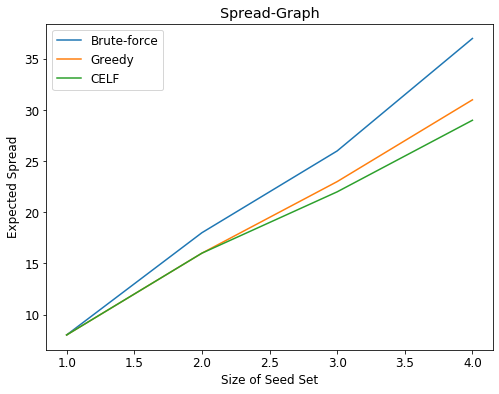

In [18]:
# plotting the points  
plt.plot(x, y1,label="Brute-force") 
plt.plot(x, y2,label="Greedy")
plt.plot(x, y3,label="CELF")
# naming the x axis 
plt.xlabel('Size of Seed Set') 
# naming the y axis 
plt.ylabel('Expected Spread') 
  
# giving a title to my graph 
plt.title('Spread-Graph') 
plt.legend()
# function to show the plot 
plt.show() 

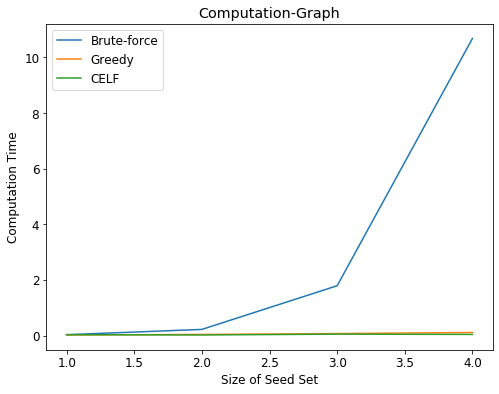

In [19]:
# plotting the points  
plt.plot(x, brute_force_elapsed1,label="Brute-force") 
plt.plot(x, greedy_elapsed1,label="Greedy")
plt.plot(x, celf_elapsed1,label="CELF")
# naming the x axis 
plt.xlabel('Size of Seed Set') 
# naming the y axis 
plt.ylabel('Computation Time') 
  
# giving a title to my graph 
plt.title('Computation-Graph') 
plt.legend()
# function to show the plot 
plt.show() 